In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important; } </style>"))

In [2]:
import pandas as pd #python's version of excel
import numpy as np #array library
import datetime as dt # for date sorting

import seaborn as sns
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
#import cv2

%matplotlib inline

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense
from keras.applications import ResNet50
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.applications.resnet50 import preprocess_input
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from sklearn import metrics

Using TensorFlow backend.
C:\Users\M323742\Anaconda3\envs\RBE595\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\M323742\Anaconda3\envs\RBE595\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\M323742\Anaconda3\envs\RBE595\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\M323742\Anaconda3\envs\RBE595

In [4]:
PATH='exp/HW_6-7/'

In [5]:
train_data_dir = f'{PATH}train'
validation_data_dir = f'{PATH}valid'

In [6]:
train_data_dir

'exp/HW_6-7/train'

In [7]:
sz=224
batch_size=64

In [8]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                   rescale=1./255,
                                   shear_range=0.05, 
                                   zoom_range=0.1, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                  rescale=1./255)



In [9]:
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    color_mode="rgb",
                                                    target_size=(sz, sz),
                                                    batch_size=batch_size, 
                                                    class_mode='categorical',
                                                    seed=42)

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        shuffle=False,
                                                        color_mode="rgb",
                                                        target_size=(sz, sz),
                                                        batch_size=batch_size, 
                                                        class_mode='categorical')

Found 54039 images belonging to 9 classes.
Found 13305 images belonging to 9 classes.


In [10]:
label2code=train_generator.class_indices;
code2label=dict((v,k) for k,v in label2code.items()) # reverse dict
label2code

{'AFernandez': 0,
 'GEncinas': 1,
 'JDong': 2,
 'MDeshmukh': 3,
 'OFowler': 4,
 'RFerrin': 5,
 'SBrewer': 6,
 'SCrawford': 7,
 'TFord': 8}

In [11]:
cat = [next(train_generator) for i in range(0,5)] 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


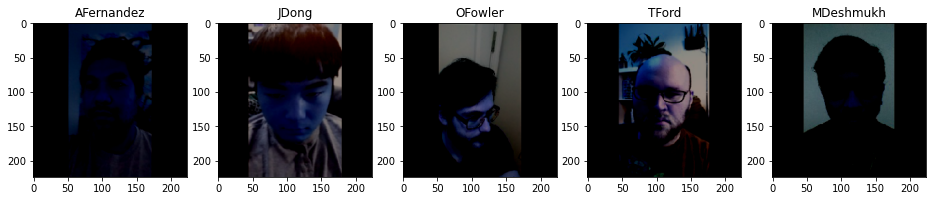

In [12]:
fig, ax = plt.subplots(1,5, figsize=(16, 6))
for  i in range(0,5):
    ax[i].imshow(cat[i][0][0]) 
    ax[i].set_title(code2label.get(np.argmax(cat[i][1][0])))

In [13]:
#input_t=K.Input(shape=(sz,sz,3))
base_model = ResNet50(weights='imagenet', include_top=False,input_shape=(sz, sz, 3))

C:\Users\M323742\Anaconda3\envs\RBE595\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [14]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [15]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(len(code2label), activation='softmax'))


In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 903177    
Total params: 24,490,889
Trainable params: 24,437,769
Non-trainable params: 53,120
_________________________________________________________________


In [17]:
for layer in base_model.layers: layer.trainable = False

In [18]:
filepath="HW78_weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [19]:
opt = Adam(learning_rate=0.003)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
#for layer in model.layers:
#    print(layer.name)

In [55]:
# Complete Do Not Run
%%time
history=model.fit_generator(generator=train_generator, 
                    steps_per_epoch=train_generator.n // batch_size, 
                    epochs=3, 
                    validation_data=validation_generator, 
                    validation_steps= validation_generator.n // batch_size,
                    callbacks=callbacks_list)

Epoch 1/3
844/844 [==============================] - 8446s 10s/step - loss: 0.0586 - accuracy: 0.9992 - val_loss: 0.0000e+00 - val_accuracy: 0.9832

Epoch 00001: val_accuracy improved from 0.57745 to 0.98324, saving model to HW78_weights_best.hdf5
Epoch 2/3
844/844 [==============================] - 8387s 10s/step - loss: 0.0184 - accuracy: 0.9997 - val_loss: 0.0000e+00 - val_accuracy: 0.9406

Epoch 00002: val_accuracy did not improve from 0.98324
Epoch 3/3
844/844 [==============================] - 8373s 10s/step - loss: 0.0049 - accuracy: 0.9999 - val_loss: 0.0000e+00 - val_accuracy: 0.9510

Epoch 00003: val_accuracy did not improve from 0.98324
Wall time: 7h 6s


In [20]:
model.load_weights("HW78_weights_best.hdf5")

In [21]:
y_pred = model.predict(validation_generator)


In [22]:
df_pred=pd.DataFrame(y_pred, columns=[f'{key}: {item}' for item, key in label2code.items()])

In [23]:
#df_pred['sum']=df_pred.sum(axis=1)

In [24]:
df_pred['files']=validation_generator.filenames

In [25]:
vfunc=np.vectorize(lambda idx: label2code.get(df_pred.loc[idx,'files'].split(chr(92))[0]))
df_pred['GroundTruth']=vfunc(df_pred.index)

In [26]:
vfunc=np.vectorize(lambda idx: np.argmax(y_pred[idx], axis=0))
df_pred['Prediction']=vfunc(df_pred.index)

In [27]:
df_pred['Incorrect']=df_pred['GroundTruth']-df_pred['Prediction']
df_pred.loc[df_pred[df_pred['Incorrect']!=0].index,'Incorrect']=1

In [28]:
df_wrong=df_pred[df_pred['Incorrect']==1].copy()

In [29]:
df_wrong.sample(6)

,0: AFernandez,1: GEncinas,2: JDong,3: MDeshmukh,4: OFowler,5: RFerrin,6: SBrewer,7: SCrawford,8: TFord,files,GroundTruth,Prediction,Incorrect
9107,0.0,0.0,0.0,0.0,0.0,1.000000e+00,6.213265e-12,0.0,0.0,SBrewer\Brewer_5frame1176.jpg,6,5,1
9066,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,1.0,0.0,SBrewer\Brewer_5frame1139.jpg,6,7,1
8893,0.0,0.0,0.0,0.0,0.0,8.005735e-15,0.000000e+00,1.0,0.0,RFerrin\ferrin5frame985.jpg,5,7,1
9123,0.0,0.0,0.0,0.0,0.0,1.000000e+00,3.805649e-23,0.0,0.0,SBrewer\Brewer_5frame1190.jpg,6,5,1
10631,0.0,0.0,0.0,0.0,0.0,1.000000e+00,1.809858e-26,0.0,0.0,SBrewer\Brewer_5frame876.jpg,6,5,1
10526,0.0,0.0,0.0,0.0,0.0,1.000000e+00,0.000000e+00,0.0,0.0,SBrewer\Brewer_5frame781.jpg,6,5,1


In [30]:
df_wrong['GroundTruth'].value_counts()

6    120
5     83
3     14
1      5
Name: GroundTruth, dtype: int64

In [31]:
df_wrong['Prediction'].value_counts()

5    94
6    69
7    48
4    10
8     1
Name: Prediction, dtype: int64

In [32]:
confusion=metrics.confusion_matrix(df_pred['GroundTruth'],df_pred['Prediction'])

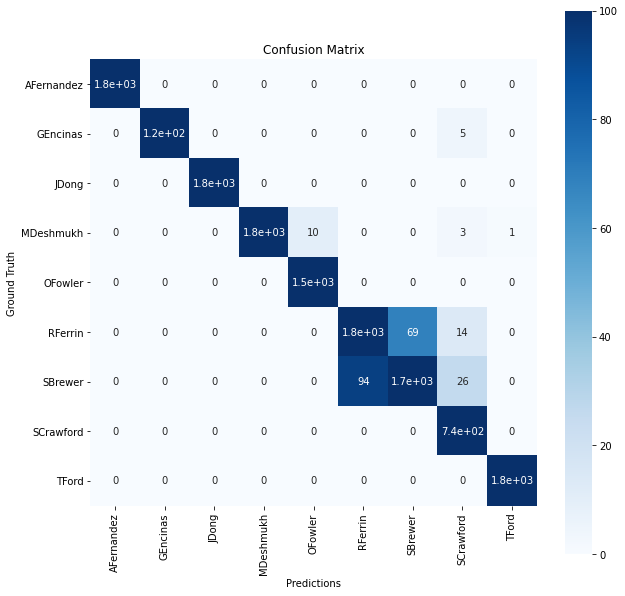

In [33]:
fig, axes = plt.subplots(1, 1, figsize=(10,10))
col=[f'{item}' for item, key in label2code.items()]
ax=sns.heatmap(confusion, annot=True, xticklabels= col,yticklabels= col, square=True, cmap='Blues', vmax=100)
ax.set_xlabel('Predictions')
ax.set_ylabel('Ground Truth')
ax.set_title('Confusion Matrix')
plt.show()

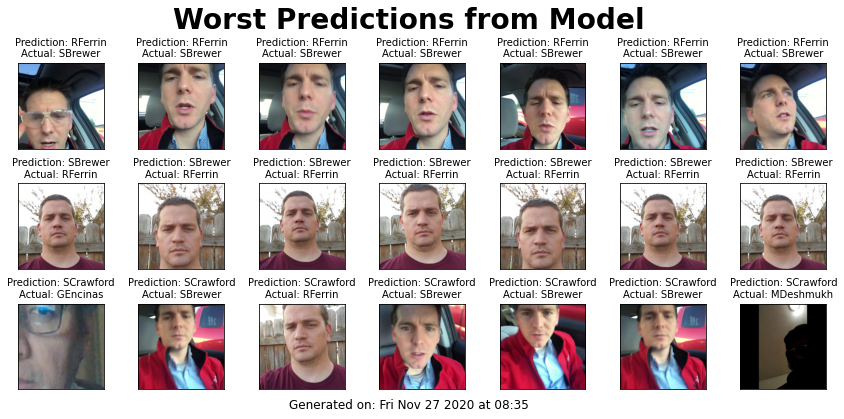

In [59]:
now=dt.datetime.now()
col=7
rows=[5,6,7]
fig, axes = plt.subplots(len(rows),col,gridspec_kw={'hspace': 0.4, 'wspace': 0.05},  figsize=(15,6))
for r, cls in enumerate(rows):
    #print(cls)
    for c in range(col):
        # Random wrong image
        index=df_wrong[df_wrong['Prediction']==cls].sample().index[0]
        fl=df_wrong.loc[index,'files']
        
        pred=code2label.get(df_wrong.loc[index,'Prediction'])
        grndtrth=code2label.get(df_wrong.loc[index,'GroundTruth'])
        
        fl=fl.replace('\\','/')
        axes[r,c].imshow(mpimg.imread(f"{validation_data_dir}/{fl}"))
        
        axes[r,c].set_title(f'Prediction: {pred}\nActual: {grndtrth}', fontsize=10)
        axes[r,c].tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
        axes[r,c].set_xticks([])
        axes[r,c].set_yticks([])

fig.suptitle('Worst Predictions from Model',y=1.01, ha='center', fontsize=28, fontweight='bold')        
plt.figtext(0.5,  .08, f'Generated on: {now.strftime("%a %b %d %Y")} at {now.strftime("%H:%M")}', 
            color='Black', ha='center',fontsize=12)
plt.show()

# Training stage 2
* Make later convolutional layers in model trainable, 
* freeze

In [20]:
model.load_weights("HW78_weights_best.hdf5")

In [21]:
# Freeze last layer
for layer in model.layers: 
    if layer.name!="resnet50":
        print(f'{layer.name}: Frozen')
        layer.trainable = False

flatten_1: Frozen
dense_1: Frozen


In [22]:
split_at = 140
# Beginning Layers Frozen
for layer in base_model.layers[:split_at]: layer.trainable = False
# Ending Convolutional Layers Trainable
for layer in base_model.layers[split_at:]: layer.trainable = True

In [23]:
# Save best under new name
filepath="HW78_weights_Stage2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [24]:
# Learingin Rate 10x smaller
opt = Adam(learning_rate=0.0003)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
%%time
history=model.fit_generator(generator=train_generator, 
                    steps_per_epoch=train_generator.n // batch_size, 
                    epochs=3, 
                    validation_data=validation_generator, 
                    validation_steps= validation_generator.n // batch_size,
                    callbacks=callbacks_list)


Epoch 1/3
844/844 [==============================] - 10456s 12s/step - loss: 0.0545 - accuracy: 0.9992 - val_loss: 0.0000e+00 - val_accuracy: 0.8849

Epoch 00001: val_accuracy improved from -inf to 0.88489, saving model to HW78_weights_Stage2.hdf5
Epoch 2/3
844/844 [==============================] - 10171s 12s/step - loss: 0.0016 - accuracy: 0.9999 - val_loss: 0.0000e+00 - val_accuracy: 0.9626

Epoch 00002: val_accuracy improved from 0.88489 to 0.96262, saving model to HW78_weights_Stage2.hdf5
Epoch 3/3
844/844 [==============================] - 10220s 12s/step - loss: 0.0300 - accuracy: 0.9996 - val_loss: 0.0000e+00 - val_accuracy: 0.9778

Epoch 00003: val_accuracy improved from 0.96262 to 0.97780, saving model to HW78_weights_Stage2.hdf5
Wall time: 8h 34min 12s


Training convolutional layers did not improve validation accuracy

In [ ]:
# Weights from training only last layers should be used
model.load_weights("HW78_weights_best.hdf5")

In [27]:
print("Finished:", dt.datetime.now())

Finished: 2020-11-27 17:33:58.961024
